## Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random, cv2, os
from glob import glob
from keras.preprocessing.image import load_img

import warnings
warnings.simplefilter('ignore')

## Downloading the dataset

Downloading the dataset using the `opendatasets` library using the url of the dataset.

In [2]:
!pip install opendatasets -q

In [3]:
import opendatasets as od

# downloading the dataset using the url
od.download('https://www.kaggle.com/tawsifurrahman/covid19-radiography-database') 

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  santhosh086


Your Kaggle Key:

  ································


100%|██████████| 745M/745M [00:14<00:00, 54.5MB/s] 


## Importing the datasets

In [4]:
# all the directories present
os.listdir('covid19-radiography-database/COVID-19_Radiography_Dataset/')

['Lung_Opacity.metadata.xlsx',
 'COVID',
 'Normal.metadata.xlsx',
 'README.md.txt',
 'Lung_Opacity',
 'Normal',
 'COVID.metadata.xlsx',
 'Viral Pneumonia',
 'Viral Pneumonia.metadata.xlsx']

In [5]:
root_dir = 'covid19-radiography-database/COVID-19_Radiography_Dataset/' # base directory of the images

# dictionary to map the different classes in the dataset
data_class_dict = {
    'COVID' : 'Covid-19',
    'Lung_Opacity' : 'Lung Opacity',
    'Normal' : 'Healthy',
    'Viral Pneumonia' : 'Viral Pneumonia'
}

# dictionary to map the different classes in the dataset in numerical form
data_code_dict = {
    'COVID' : 0,
    'Lung_Opacity' : 1,
    'Normal' : 2,
    'Viral Pneumonia' : 3
}

In [6]:
# getting the images as dictionary
# keys are the respective image id
# values are the path of the respective image

image_id_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(
                                                                     root_dir, '*', '*png'))}

In [7]:
# sample of how the image_id_path_dict looks like for each class

print(list(image_id_path_dict.items())[0])
print(list(image_id_path_dict.items())[-5])
print(list(image_id_path_dict.items())[2000])
print(list(image_id_path_dict.items())[15000])

('COVID-2317', 'covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-2317.png')
('Viral Pneumonia-931', 'covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-931.png')
('COVID-2678', 'covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-2678.png')
('Normal-5622', 'covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-5622.png')


In [8]:
# creating a dataframe using the dictionary created
# with the image_id and its respective path as columns

covid_df = pd.DataFrame.from_dict(image_id_path_dict, orient = 'index').reset_index()
covid_df.columns = ['Image_id', 'Path']

# creating a new column class using the image_id
covid_df['class'] = covid_df['Image_id'].apply(lambda x:x.split('-')[0]) # getting the first element after splitting
covid_df.head()

,Image_id,Path,class
0,COVID-2317,covid19-radiography-database/COVID-19_Radiogra...,COVID
1,COVID-1166,covid19-radiography-database/COVID-19_Radiogra...,COVID
2,COVID-1652,covid19-radiography-database/COVID-19_Radiogra...,COVID
3,COVID-3101,covid19-radiography-database/COVID-19_Radiogra...,COVID
4,COVID-2942,covid19-radiography-database/COVID-19_Radiogra...,COVID


In [9]:
# mapping the values to the class column
# to the dictionary data_class_dict using map()

covid_df['Class'] = covid_df['class'].map(data_class_dict.get)
covid_df['Class'].value_counts()

Healthy            10192
Lung Opacity        6012
Covid-19            3616
Viral Pneumonia     1345
Name: Class, dtype: int64

In [10]:
# mapping numerical values to the class column
# to the dictionary data_code_dict using map()

covid_df['Target'] = covid_df['class'].map(data_code_dict.get)
covid_df['Target'].value_counts()

2    10192
1     6012
0     3616
3     1345
Name: Target, dtype: int64

## Data Preprocessing

In [11]:
total_samples = covid_df.shape[0] # number of rows
null_samples = covid_df.isna().sum().sum() # number of nan values
duplicate_samples = covid_df.duplicated().sum() # number of duplicate values

print('Number of Image samples :',total_samples)
print('Number of Null samples :', null_samples)
print('Number of Duplicate samples :', duplicate_samples)

Number of Image samples : 21165
Number of Null samples : 0
Number of Duplicate samples : 0


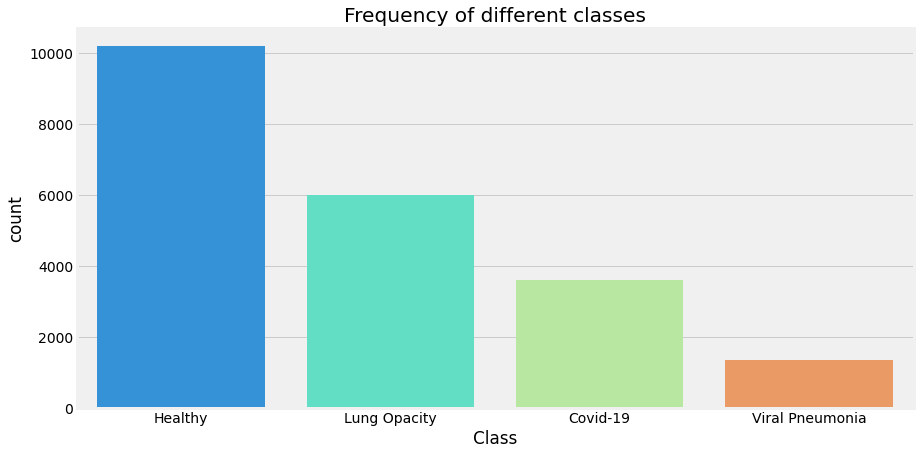

In [12]:
plt.figure(figsize = (15, 7))
plt.style.use('fivethirtyeight')
sns.countplot(covid_df['Class'], order = covid_df['Class'].value_counts().index, palette = 'rainbow')

plt.title('Frequency of different classes')
plt.show();

In [13]:
# getting the percentage of each samples in the dataset

healthy_samples_per = (covid_df[covid_df['Class'] == 'Healthy'].shape[0]/covid_df.shape[0])*100
opacity_samples_per = (covid_df[covid_df['Class'] == 'Lung Opacity'].shape[0]/covid_df.shape[0])*100
covid_samples_per = (covid_df[covid_df['Class'] == 'Covid-19'].shape[0]/covid_df.shape[0])*100
pneumonia_samples_per = (covid_df[covid_df['Class'] == 'Viral Pneumonia'].shape[0]/covid_df.shape[0])*100

In [14]:
print('Proportion of Healthy samples :{:.2f}'.format(healthy_samples_per))
print('Proportion of Lung Opacity samples :{:.2f}'.format(opacity_samples_per))
print('Proportion of Covid-19 samples :{:.2f}'.format(covid_samples_per))
print('Proportion of Viral Pneumonia samples :{:.2f}'.format(pneumonia_samples_per))

Proportion of Healthy samples :48.15
Proportion of Lung Opacity samples :28.41
Proportion of Covid-19 samples :17.08
Proportion of Viral Pneumonia samples :6.35


* We can see that the number of Healthy images and Lung Opacity images comprises about 80% of the dataset.
* Covid-19 images which we need to predict only comprises about 17%.
* This clearly shows that the dataset is quite imbalanced.

In [15]:
# resizing the shape of the images 
# and adding it to the dataframe

covid_df['Image'] = covid_df['Path'].apply(lambda x:np.asarray(Image.open(x).resize((75, 75))))

In [16]:
# function to display random images with respect to class

def display_image(class_type):
    plt.figure(figsize = (15, 8)) # setting the figure size

    temp = covid_df[covid_df['Class'] == class_type]['Path'] # getting the image path of the class
    start = random.randint(0, len(temp)) # selecting a random starting index
    files = temp[start:start+3] # getting the next 2 image paths

    for index, file in enumerate(files):
        plt.subplot(1, 3, index+1)
        img = load_img(file) # loading the image
        img = np.array(img) # converting the image to an array
        plt.imshow(img) # displaying the image
        plt.title(class_type) # title for the image
        plt.axis('off') # disabling the axis

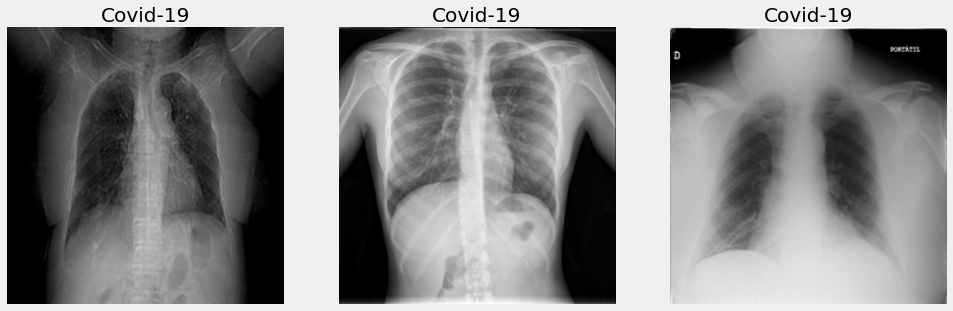

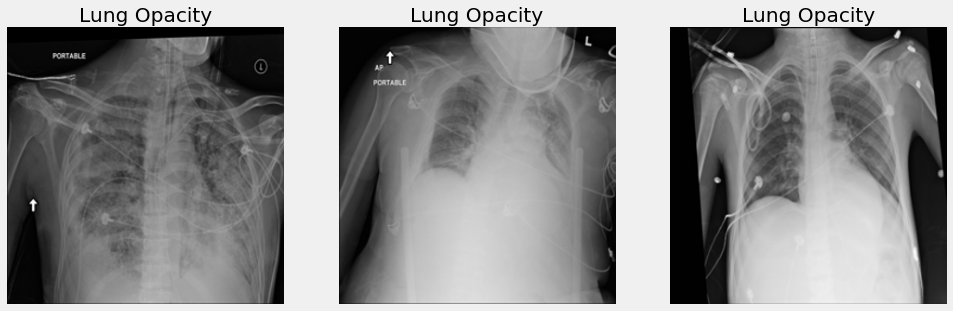

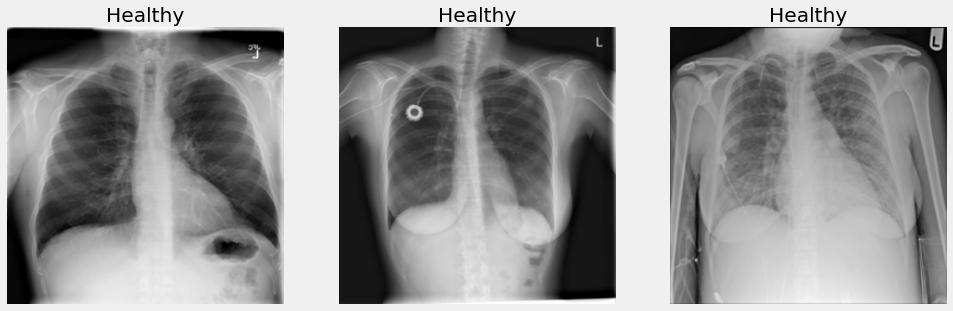

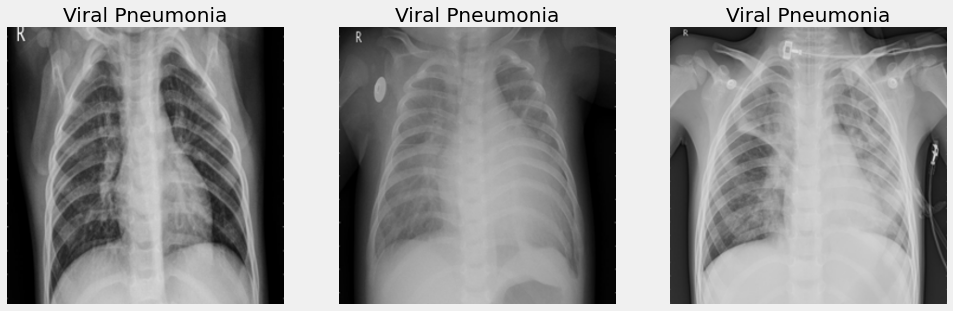

In [17]:
# 3 random images for each class

for cls in covid_df['Class'].unique():
    display_image(cls)

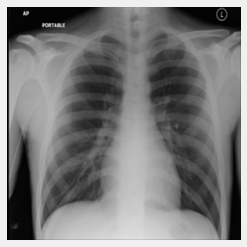

In [18]:
# getting the basic parameters of the image

plt.figure()
pic_id = random.randrange(0, len(covid_df))
picture = covid_df['Path'][pic_id]
image = cv2.imread(picture)
plt.imshow(image)
plt.axis('off');
plt.show() 

In [19]:
# basic parameters of the image in the dataset

print('Shape of the image : {}'.format(image.shape))
print('Image Hight {}'.format(image.shape[0]))
print('Image Width {}'.format(image.shape[1]))
print('Dimension of Image {}'.format(image.ndim))
print('Image size {}'.format(image.size))
print('Image Data Type {}'.format(image.dtype))
print('Maximum RGB value in this image {}'.format(image.max()))
print('Minimum RGB value in this image {}'.format(image.min()))

Shape of the image : (299, 299, 3)
Image Hight 299
Image Width 299
Dimension of Image 3
Image size 268203
Image Data Type uint8
Maximum RGB value in this image 226
Minimum RGB value in this image 0


In [20]:
mean_val = [] # list to store mean values of different class
std_dev_val = [] # list to store standard deviation values of different class
max_val = [] # list to store maximum values of different class
min_val = [] # list to store minimum values of different class

for i in range(0,len(covid_df)):
    mean_val.append(covid_df['Image'][i].mean()) # appendig the mean
    std_dev_val.append(np.std(covid_df['Image'][i])) # appendig the mean
    max_val.append(covid_df['Image'][i].max()) # appendig the maximum value
    min_val.append(covid_df['Image'][i].min()) # appendig the minimum value

# creating a new dataframe with Image array, Image class and Image path
# along with it we also add the mean, standard deviation
# minimum and maximum values of each class to the dataframe
image_eda = covid_df.loc[:,['Image', 'Class','Path']]
image_eda['mean'] = mean_val
image_eda['std_dev'] = std_dev_val
image_eda['max'] = max_val
image_eda['min'] = min_val

subt_mean_samples = image_eda['mean'].mean() - image_eda['mean']
image_eda['subt_mean'] = subt_mean_samples

In [21]:
image_eda.head(3)

,Image,Class,Path,mean,std_dev,max,min,subt_mean
0,"[[32, 31, 32, 32, 32, 31, 31, 31, 30, 30, 28, ...",Covid-19,covid19-radiography-database/COVID-19_Radiogra...,142.438578,43.642925,-39,11,-12.506963
1,"[[149, 163, 165, 161, 167, 159, 149, 142, 133,...",Covid-19,covid19-radiography-database/COVID-19_Radiogra...,141.182222,77.068196,-1,0,-11.250607
2,"[[190, 188, 137, 83, 86, 92, 94, 81, 76, 80, 1...",Covid-19,covid19-radiography-database/COVID-19_Radiogra...,147.609244,25.346036,-52,66,-17.677630


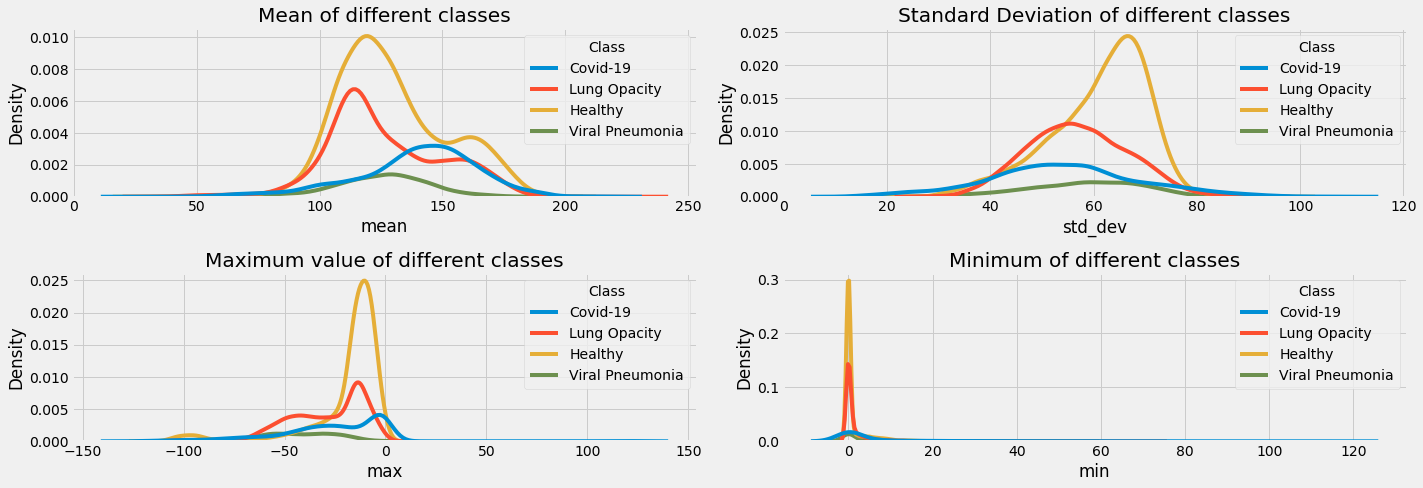

In [22]:
# plotting values like mean, standard deviation, minimum and maximum values obtained
# with respect to each class using a kde plot

plt.figure(figsize = (20, 7))

plt.subplot(2, 2, 1)
sns.kdeplot(x = image_eda['mean'], hue = image_eda['Class']) # mean with respect to each class
plt.title('Mean of different classes') # title

plt.subplot(2, 2, 2)
sns.kdeplot(x = image_eda['std_dev'], hue = image_eda['Class']) # sta_dev with respect to each class
plt.title('Standard Deviation of different classes') # title

plt.subplot(2, 2, 3)
sns.kdeplot(x = image_eda['max'], hue = image_eda['Class']) # maximum values with respect to each class
plt.title('Maximum value of different classes') # title

plt.subplot(2, 2, 4)
sns.kdeplot(x = image_eda['min'], hue = image_eda['Class']) # minimum values with respect to each class
plt.title('Minimum of different classes') # title

plt.tight_layout()

* We can see that Healthy class has higher peaks compared to other classes.


## Model Building

In [23]:
from keras.preprocessing.image import ImageDataGenerator

In [24]:
base_dir = 'covid19-radiography-database/COVID-19_Radiography_Dataset/' # base directory of the image

classes = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"] # all the classes
num_classes = len(classes)

batch_size = 32 

# parameters to create the training and validation set images 
# and data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale = 1./255, # normalizing the pixel value of images
    horizontal_flip = True, # used for randomly flipping the  inputs horizontally. 
    width_shift_range = 0.2, # specifying the range to be shifted on the left and right sides
    height_shift_range = 0.2, # specifying the range to be shifted on the top and bottom sides
    zoom_range = 0.2,
    rotation_range = 20, # specifying the rotation angle
    validation_split = 0.2
)

# No data augmentation is performed on test data images
test_datagen = ImageDataGenerator(
    rescale = 1./255, # normalizing the pixel value of images
    validation_split = 0.2 # percentage of validation data
)

In [25]:
# loading the images for training
train_gen = train_datagen.flow_from_directory(
    directory = base_dir, # directory of the image
    target_size = (256, 256), # size of the image
    class_mode = 'categorical', # type of classification
    shuffle = True, # enabling shuffling within the images
    subset = 'training',
    classes = classes, # passig the list of classes
    batch_size = batch_size, # setting the batch size
    color_mode = 'grayscale' # setting the color mode
)

# loading the images for testing
test_gen = test_datagen.flow_from_directory(
    directory = base_dir, # directory of the images
    class_mode = 'categorical', # tyoe of classification
    subset = 'validation',
    shuffle = False, # dusabling shuffling within the images
    batch_size = batch_size, # setting the batch size
    color_mode = 'grayscale' # setting the color mode
)

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [27]:
# setting up the cnn model

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),activation='relu',padding = 'Same', input_shape=(256, 256, 1))) # convolutional layer
model.add(BatchNormalization()) # layer for 
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same')) # convolutional layer
model.add(BatchNormalization()) # layer for batch normalization
model.add(MaxPooling2D(pool_size = (2, 2))) # layer for max pooling
model.add(Dropout(0.25)) # layer for dropout

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same')) # convolutional layer
model.add(BatchNormalization()) # layer for batch normalization

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same')) # convolutional layer
model.add(BatchNormalization()) # layer for batch normalization
model.add(MaxPooling2D(pool_size=(2, 2))) # layer for max pooling
model.add(Dropout(0.25)) # layer for dropout
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same')) # convolutional layer
model.add(BatchNormalization()) # layer for batch normalization
model.add(MaxPooling2D(pool_size = (2, 2))) # layer for max pooling
model.add(Dropout(0.25)) # layer for dropout

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same')) # convolutional layer
model.add(BatchNormalization()) # layer for batch normalization

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same')) # convolutional layer
model.add(BatchNormalization()) # layer for batch normalization
model.add(MaxPooling2D(pool_size=(2, 2))) # layer for max pooling
model.add(Dropout(0.25)) # layer for dropout

model.add(Flatten()) # flattening the image array

model.add(BatchNormalization()) # layer for batch normalization
model.add(Dense(128, activation='relu')) # Dense layer
model.add(Activation('relu'))
model.add(Dropout(0.25)) # layer for dropout

model.add(BatchNormalization()) # layer for batch normalization
model.add(Dense(128, activation='relu')) # Dense layer
model.add(Activation('relu'))
model.add(Dropout(0.25)) # layer for dropout

model.add(Flatten()) # flattening the image array

model.add(BatchNormalization()) # layer for batch normalization
model.add(Dense(256, activation='relu')) # Dense layer
model.add(Activation('relu'))
model.add(Dropout(0.25)) # layer for dropout

#Output
model.add(BatchNormalization()) # layer for batch normalization
model.add(Dense(num_classes, activation='softmax')) # Dense layer

2022-01-13 03:41:35.068595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 03:41:35.197455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 03:41:35.199105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 03:41:35.203210: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [28]:
# compiling the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# early stopping parameter with patience of 10 epochs
early_stopping = EarlyStopping(patience = 25, mode = 'min', verbose = 0) 

# learing rate reduction when the validation accuracy does not improve
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 15, verbose = 0, 
                                            factor = 0.5, min_lr = 0.00001)

callbacks = [early_stopping, learning_rate_reduction]

In [30]:
epochs = 100

history = model.fit(train_gen, validation_data = test_gen, 
                    steps_per_epoch = train_gen.samples // batch_size, 
                    validation_steps = test_gen.samples // batch_size,
                    epochs = epochs, callbacks = [callbacks])

2022-01-13 03:41:38.857303: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-13 03:41:42.321097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


529/529 [==============================] - 172s 306ms/step - loss: 1.1067 - accuracy: 0.5619 - val_loss: 1.8665 - val_accuracy: 0.3201
Epoch 2/100
529/529 [==============================] - 158s 299ms/step - loss: 0.8394 - accuracy: 0.6620 - val_loss: 0.7567 - val_accuracy: 0.6892
Epoch 3/100
529/529 [==============================] - 158s 299ms/step - loss: 0.7430 - accuracy: 0.7068 - val_loss: 0.7406 - val_accuracy: 0.6726
Epoch 4/100
529/529 [==============================] - 160s 302ms/step - loss: 0.6770 - accuracy: 0.7341 - val_loss: 1.3123 - val_accuracy: 0.4801
Epoch 5/100
529/529 [==============================] - 166s 314ms/step - loss: 0.6392 - accuracy: 0.7551 - val_loss: 0.9197 - val_accuracy: 0.6541
Epoch 6/100
529/529 [==============================] - 163s 307ms/step - loss: 0.6501 - accuracy: 0.7458 - val_loss: 1.2126 - val_accuracy: 0.5367
Epoch 7/100
529/529 [==============================] - 164s 309ms/step - loss: 0.5739 - accuracy: 0.7777 - val_loss: 0.7243 - val_

In [39]:
test_pred = model.predict(test_gen)
test_pred

array([[4.6610039e-02, 9.5164758e-01, 1.7423818e-03, 8.3931821e-09],
       [6.6584629e-01, 3.3399174e-01, 1.5871039e-04, 3.2777787e-06],
       [9.9992037e-01, 4.3992923e-08, 7.9586745e-05, 9.9490354e-09],
       ...,
       [2.8561030e-06, 5.1451934e-06, 1.1234221e-01, 8.8764977e-01],
       [8.0192531e-04, 5.5543883e-03, 7.8891357e-03, 9.8575461e-01],
       [8.0579239e-06, 3.4824801e-08, 2.4214081e-04, 9.9974972e-01]],
      dtype=float32)

In [32]:
# evaluating the model on the test data

model.evaluate_generator(test_gen)

[0.21114581823349, 0.9239130616188049]

## Visualizing the Results

In [33]:
acc = history.history['accuracy'] # training accuracy
val_acc = history.history['val_accuracy'] # validation accuracy
epochs = range(len(acc)) # number of epochs

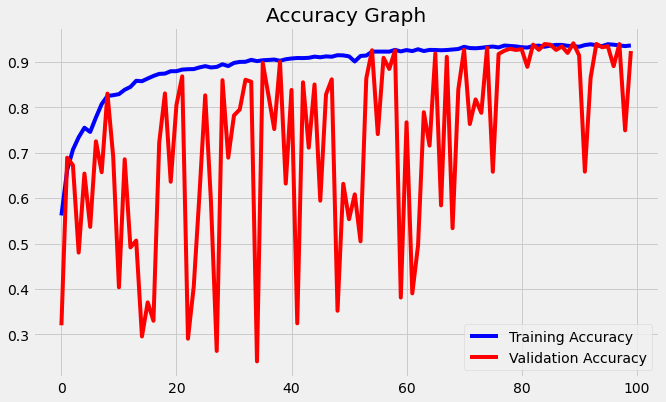

In [34]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (10, 6))
plt.plot(epochs, acc, 'b', label='Training Accuracy') # line plot for training accuracy
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy') # line plot for validation accuracy
plt.title('Accuracy Graph') # title of the plot
plt.legend() # setting legend for the plot

In [35]:
loss = history.history['loss'] # training accuracy
val_loss = history.history['val_loss'] # validation accuracy

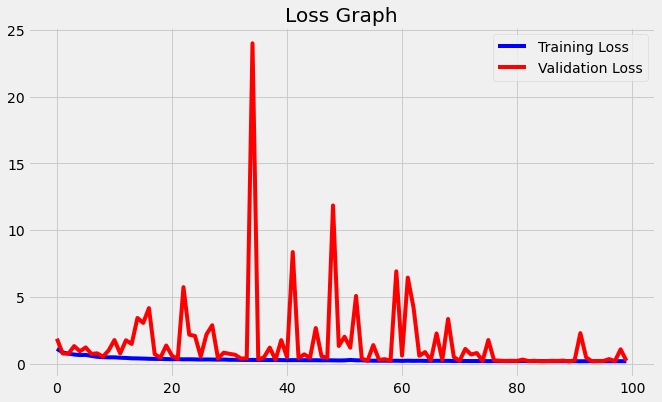

In [36]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (10, 6))

plt.plot(epochs, loss, 'b', label='Training Loss') # line plot of training loss
plt.plot(epochs, val_loss, 'r', label='Validation Loss') # line plot of validation loss
plt.title('Loss Graph') # title of the plot
plt.legend() # setting lrgrnd for the plot
plt.show()

In [37]:
model.save('model.h5')